# The Product Pricer
A model that can estimate how much something costs, from its description.

In this project, we will make use of the Amazon reviews dataset. Specifically, we will retrieve the descriptions and meta information (features) that comes with each product along with the prices (target).

Let's go!

-------
-------
-------

## Data Curation Part 1
We'll begin our scrubbing and curating our dataset by focusing on a subset of the data: Home Appliances.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [1]:
# imports
import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from datasets import load_dataset, Dataset, DatasetDict

# ML imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# llm imports
from openai import OpenAI
from anthropic import Anthropic

# NLP related imports
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# custom functions  -->  check out the python files: items.py, loaders.py, testing.py
from loaders import ItemLoader
from items import Item
from testing import Tester

In [2]:
# environment
load_dotenv(override=True)
os.environ['OPENAI_API_KEY']    = os.getenv('OPENAI_API_KEY',    'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN']          = os.getenv('HF_TOKEN',          'your-key-if-not-using-env')
openai = OpenAI()
claude = Anthropic()

In [3]:
# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
%matplotlib inline

### Load our dataset

In the next cell, we load in the dataset from huggingface.

If this gives you an error like "trust_remote_code is no longer supported", then please run this command in a new cell: `!pip install datasets==3.6.0` and then restart the Kernel, and try again.

In [5]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [6]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [7]:
# Investigate a particular datapoint
datapoint = dataset[0]

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)
[]
['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food', '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like', '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take it out and make you cool', '【Full Monitoring】 Designed with compressor cooling system, operates at low noise and will 

In [8]:
# How many have prices?
prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [9]:
# For those with prices, gather the price and the length
prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

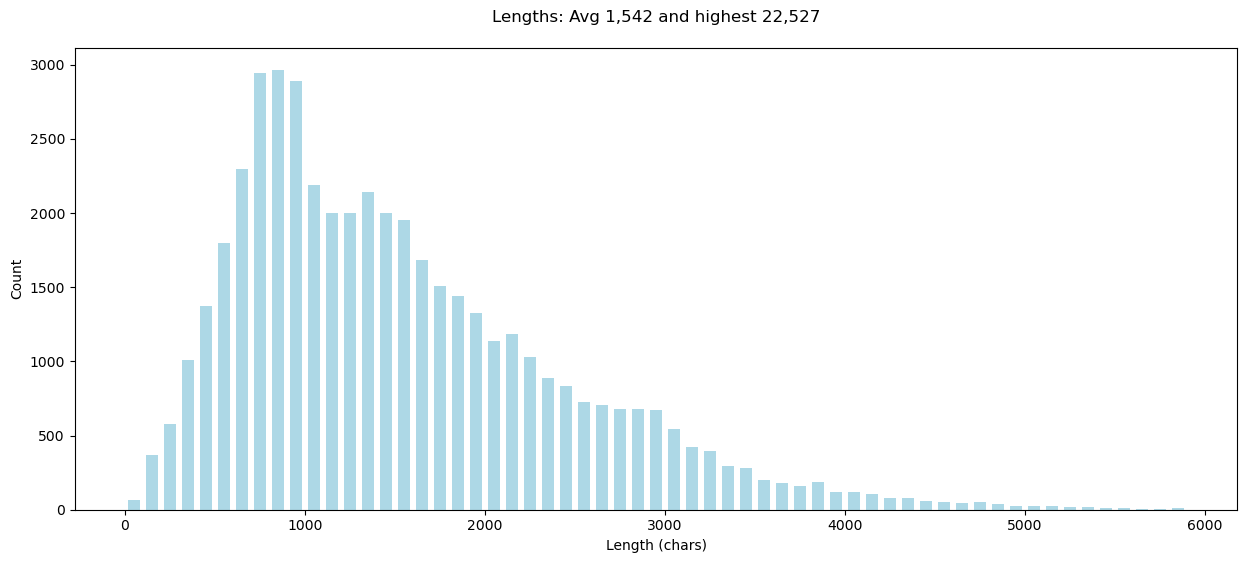

In [10]:
# Plot the distribution of lengths
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

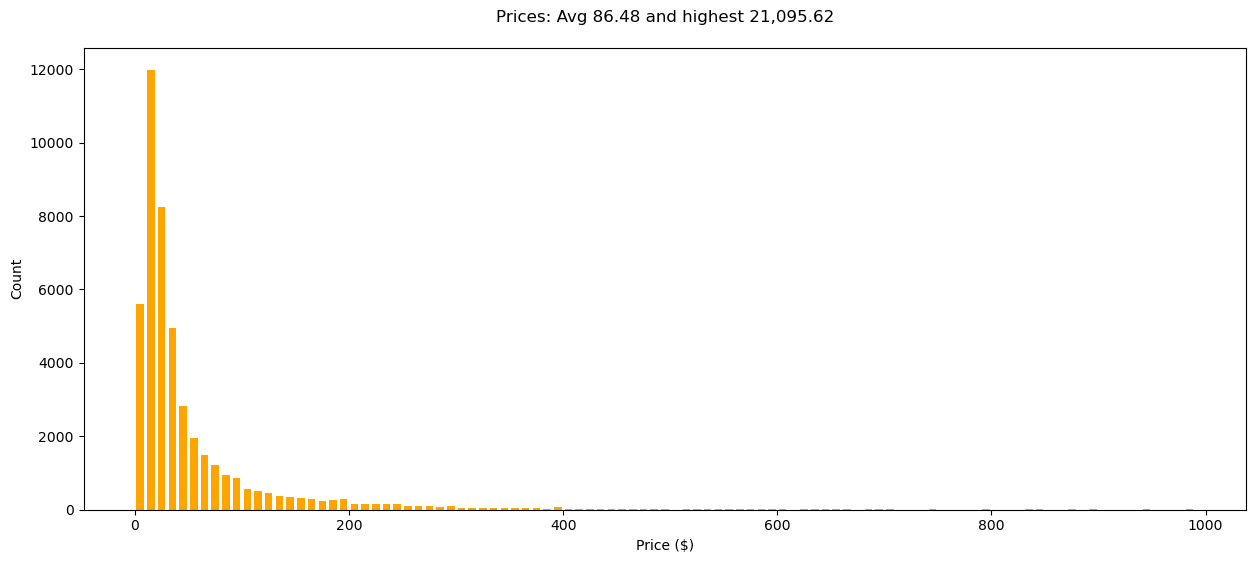

In [11]:
# Plot the distribution of prices
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [12]:
# So what is this item that is priced over 21K??
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


### Now it's time to curate our dataset

We select items that cost between 1 and 999 USD

We will be create Item instances, which truncate the text to fit within 180 tokens using the right Tokenizer

And will create a prompt to be used during Training.

Items will be rejected if they don't have sufficient characters.

### But why 180 tokens??

A student asked me a great question - why are we truncating to 180 tokens? How did we determine that number? (Thank you Moataz A. for the excellent question).

The answer: this is an example of a "hyper-parameter". In other words, it's basically trial and error! We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. You'll see this in action in Week 7.

I started with a number that seemed reasonable, and experimented with a few variations before settling on 180. If you have time, you should do the same! You might find that you can beat my results by finding a better balance. This kind of trial-and-error might sound a bit unsatisfactory, but it's a crucial part of the data science R&D process.

There's another interesting reason why we might favor a lower number of tokens in the training data. When we eventually get to use our model at inference time, we'll want to provide new products and have it estimate a price. And we'll be using short descriptions of products - like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.

### But I see in items.py it constrains inputs to 160 tokens?

Another great question from Moataz A.! The description of the products is limited to 160 tokens because we add some more text before and after the description to turn it into a prompt. That brings it to around 180 tokens in total.

In [13]:
# Create an Item object for each with a price
items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [14]:
# Look at the first item
items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [15]:
# Investigate the prompt that will be used during training - the model learns to complete this
print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [16]:
# Investigate the prompt that will be used during testing - the model has to complete this
print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


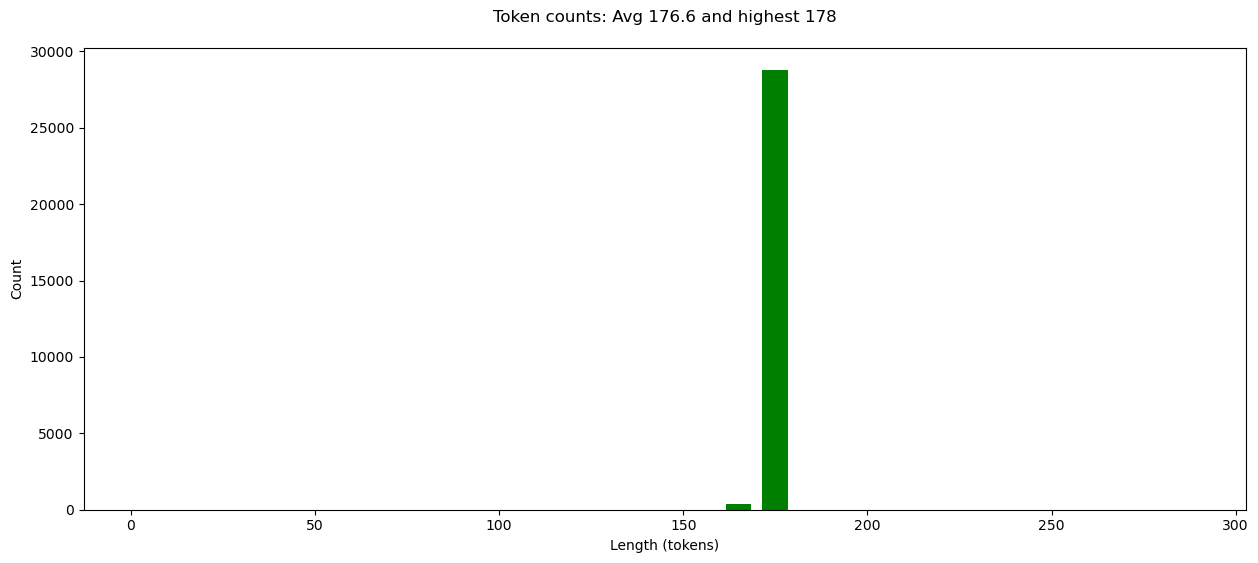

In [17]:
# Plot the distribution of token counts
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

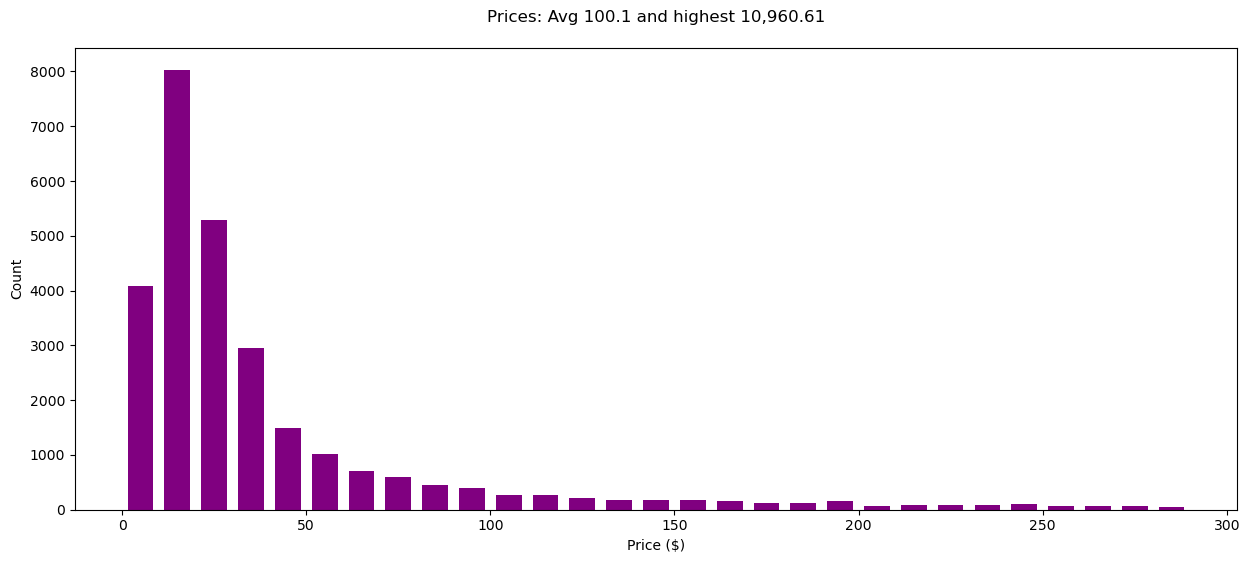

In [18]:
# Plot the distribution of prices
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

-------
-------
-------

## Data Curation Part 2

We'll do the same thing as above but use the custom classes ItemLoader and Item to read the data. After that, we'll perform a train-test split to prepare for the regression exercise.

In [19]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]

In [20]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())
print(f"A grand total of {len(items):,} items")

Loading dataset Appliances


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:58<00:00,  1.62it/s]


Completed Appliances with 28,625 datapoints in 1.4 mins
A grand total of 28,625 items


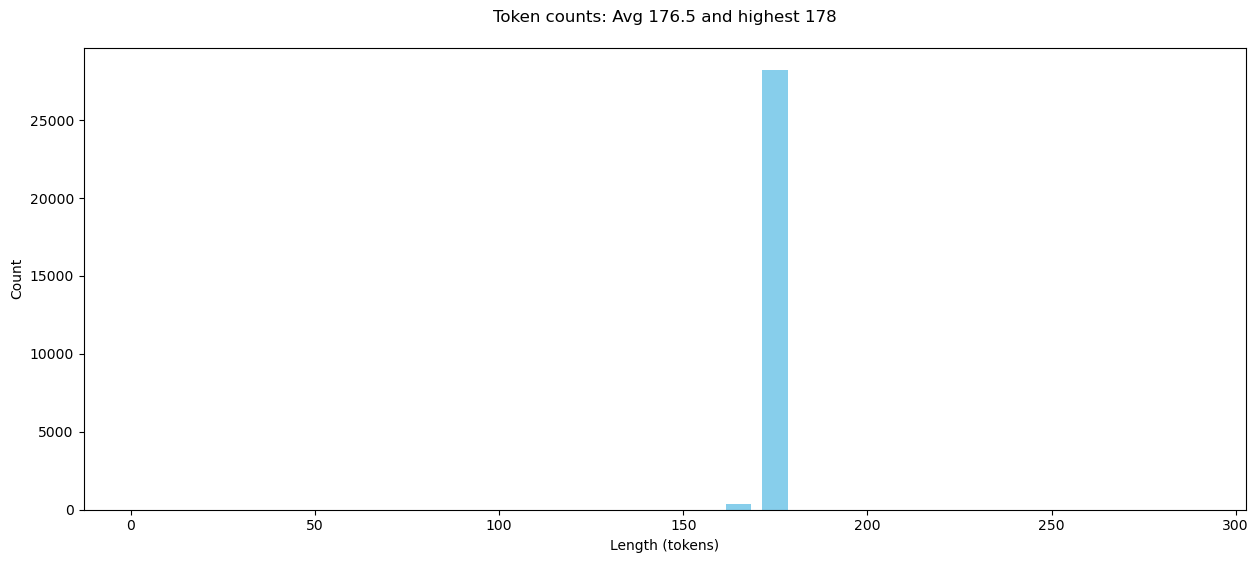

In [21]:
# Plot the distribution of token counts again
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

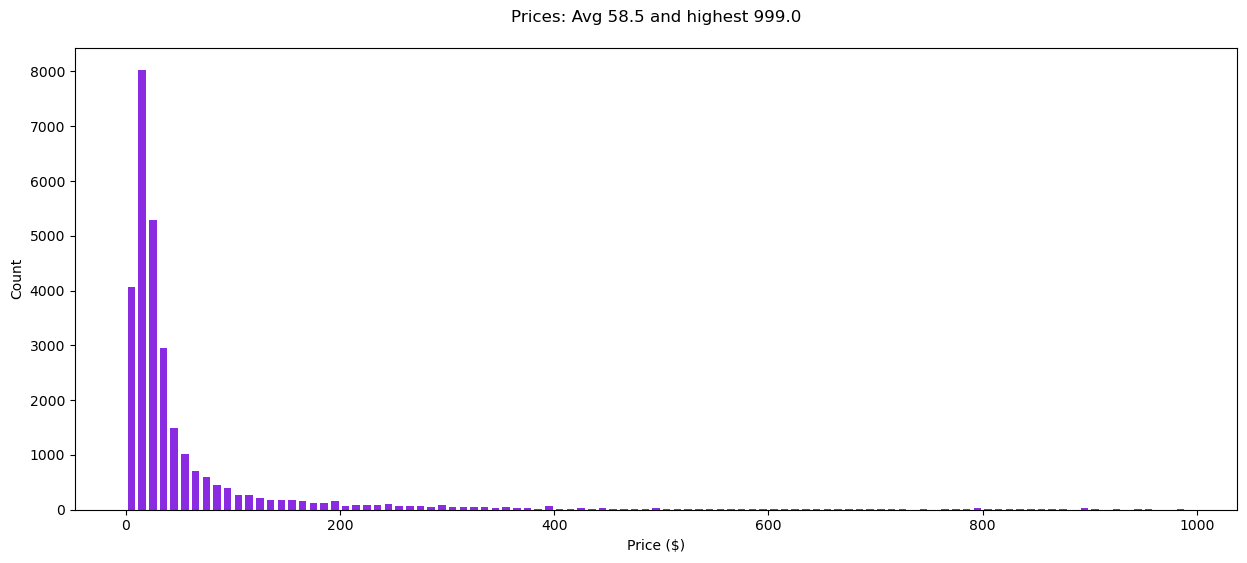

In [22]:
# Plot the distribution of prices
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

### A few final checks
We've crafted an excellent dataset. Let's do some final checks.

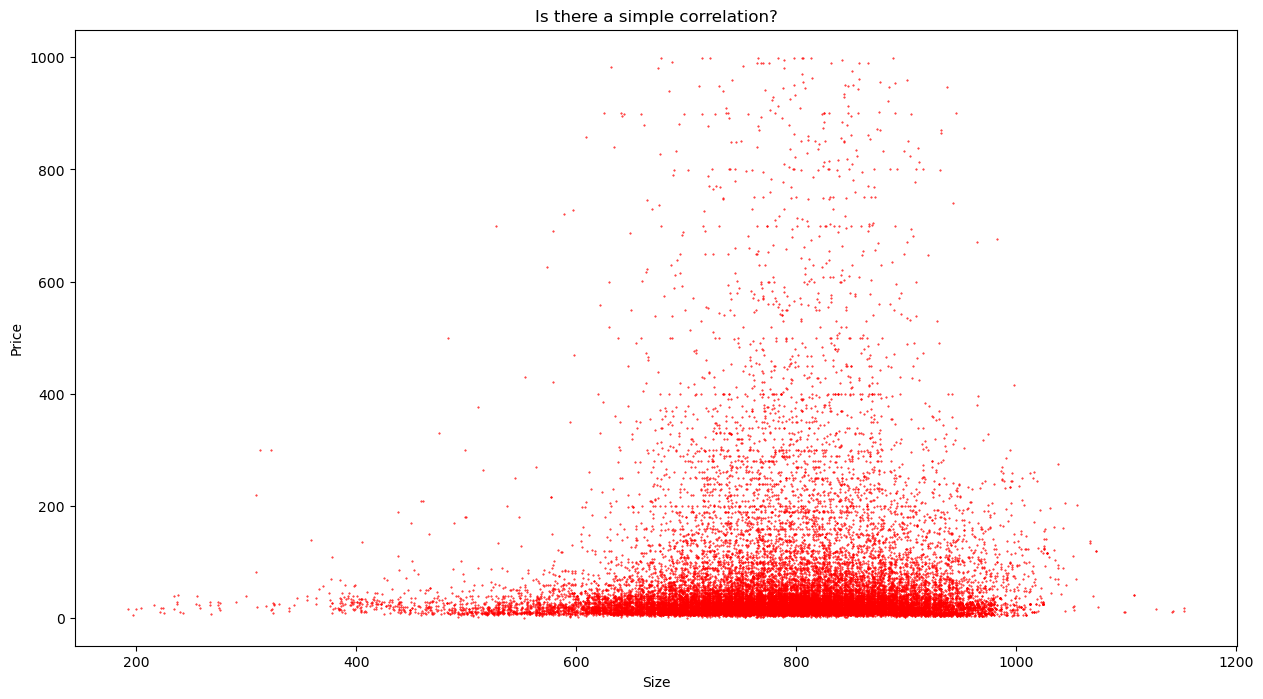

In [23]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [24]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [25]:
report(sample[50])

How much does this cost to the nearest dollar?

285746 OR 285811 Washer Agitator Support And Dogs Compatible with Inglis, Whirlpool, Kenmore, Roper, Admiral
285746 OR 285811 Agitator support and dogs Washing machine agitator repair kit with a medium length cam Agitator support and dogs for two piece agitators.This kit should be used when the top part of the agitator is not moving properly but the bottom part is. Replaces Old Numbers 2744 285746 285811 Washer Agitator Repair Kit. This part works with the following brands Whirlpool, Roper, Admiral, Maytag, Hardwick, Jenn-Air, Estate, Magic Chef, Crosley, Inglis, Norge, Modern Maid, Amana, Kenmore

Price is $8.00
[11, 14594, 6518, 271, 7117, 374, 400, 23, 13, 410]
[',', ' Ken', 'more', '\n\n', 'Price', ' is', ' $', '8', '.', '00']


### Observation
An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

### Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 25,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [26]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


In [27]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [28]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


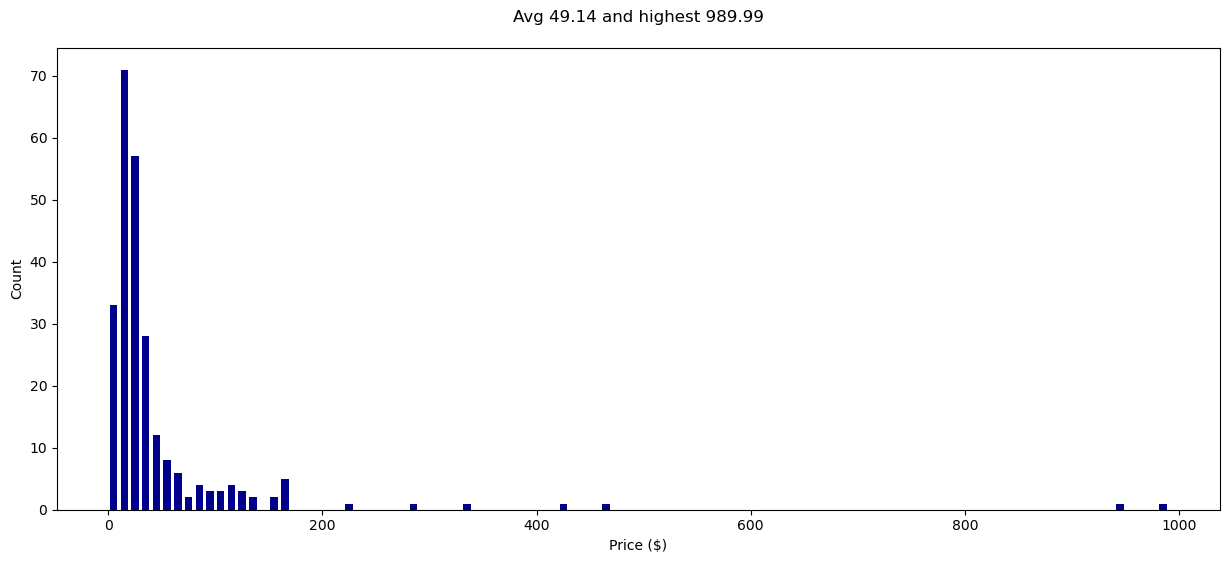

In [29]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

### Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [30]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [31]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [32]:
# push dataset to hugging face

DATASET_NAME = "ALiZaTo/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ALiZaTo/lite-data/commit/11c6224bdc159fe5daf435d7beab66e3f7290a94', commit_message='Upload dataset', commit_description='', oid='11c6224bdc159fe5daf435d7beab66e3f7290a94', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ALiZaTo/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ALiZaTo/lite-data'), pr_revision=None, pr_num=None)

In [33]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!
with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)
with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)

### Note about the pkl files above
Notice the prefix "_lite" at the end of each of their filenames.

The curated datasets that were generated above are smaller than they should be if we're gonna create a proper regressor. On the other hand, acquiring the real dataset to use in training properly is very time-consuming (12 GB download).

If you curate the BIG dataset, check out (https://github.com/ed-donner/llm_engineering/blob/main/week6/day2.ipynb)[this notebook].

If you wish to use the BIG dataset but do not want to curate it itself (a process that may take hours depending on your GPU), you may download the curated dataset (~600GB):  
https://drive.google.com/drive/folders/1f_IZGybvs9o0J5sb3xmtTEQB3BXllzrW

-------
-------
-------

## Prediction Time!

We'll try all sorts of different models. We'll start with some baseline models and then end with the LLM regressors.

Let's have some fun!

Side note:
The code below assumes that you downloaded the curated dataset from https://drive.google.com/drive/folders/1f_IZGybvs9o0J5sb3xmtTEQB3BXllzrW and put the `train.pkl` and `test.pkl` files next to this notebook.

In [45]:
# load the pkl files
# train_pkl = 'train_lite.pkl'
# test_pkl  = 'test_lite.pkl'
train_pkl = 'train.pkl'
test_pkl  = 'test.pkl'
with open(train_pkl, 'rb') as file:
    train = pickle.load(file)
with open(test_pkl, 'rb') as file:
    test = pickle.load(file)

# Remind ourselves the training prompt
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [46]:
# target
print(train[0].price)

226.95


### Model 1: Random Pricer

In [47]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

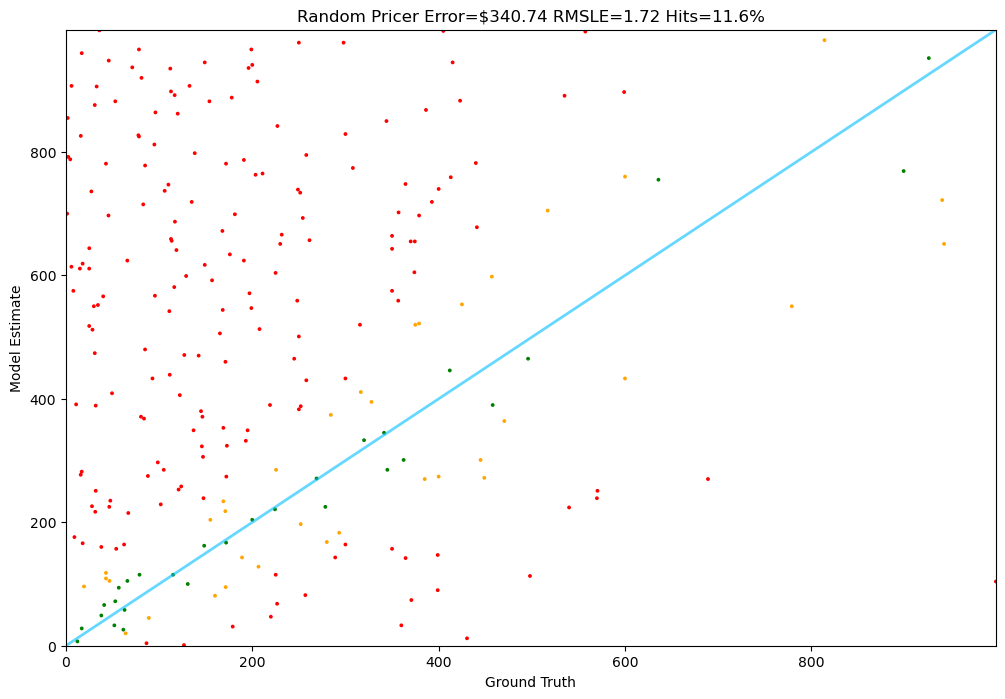

In [48]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer, test)

### Model 2: Average Pricer

In [49]:
training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

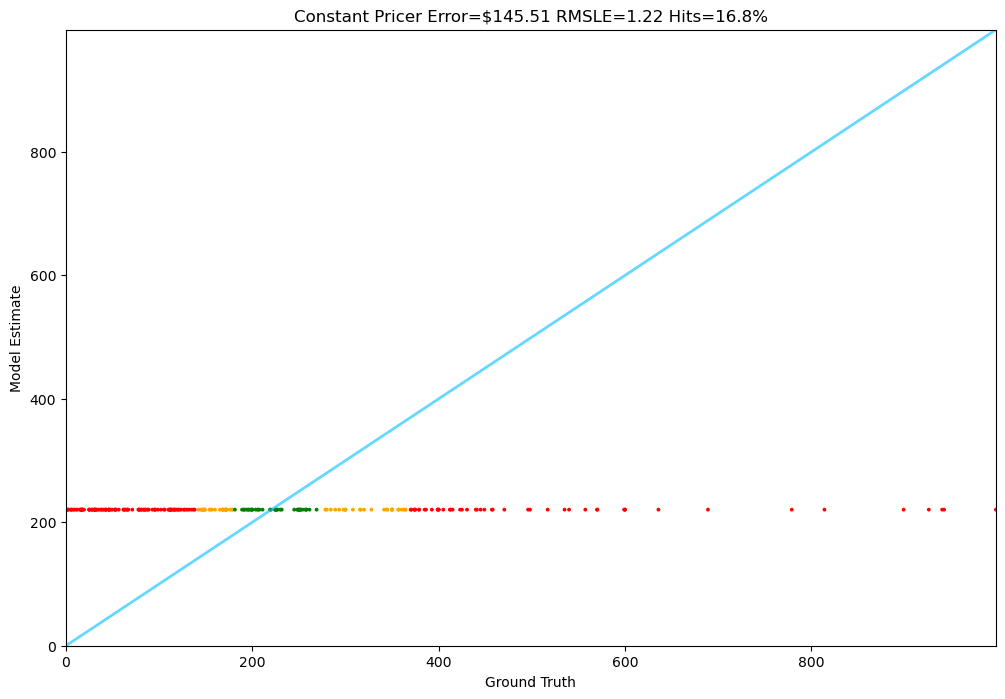

In [50]:
# Run our constant predictor
Tester.test(constant_pricer, test)

### Model 3: Bag of Words

In [55]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [56]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [57]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.58 Truth: $374.41 Error: $77.83 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.14 Truth: $599.99 Error: $273.85 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.82 Truth: $101.79 Error: $243.03 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.57 Truth: $635.86 Error: $231.29 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.13 Truth: $65.99 Error: $45.14 SLE: 0

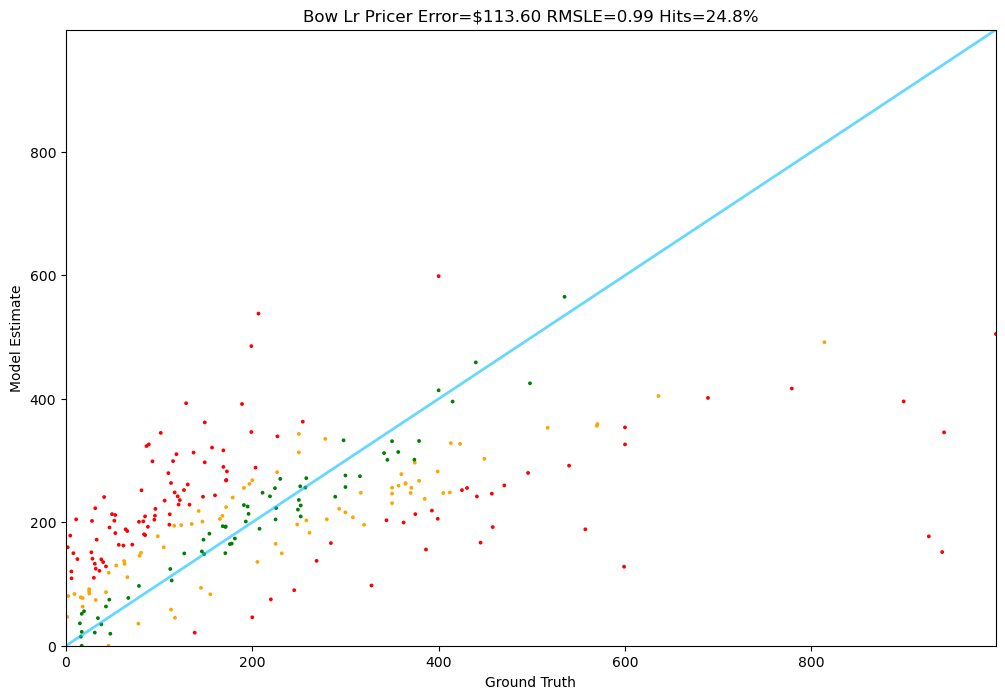

In [58]:
# test it

Tester.test(bow_lr_pricer, test)

### Model 4: Word2Vec

In [59]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [60]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [61]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [62]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $237.13 Truth: $374.41 Error: $137.28 SLE: 0.21 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $169.47 Truth: $225.11 Error: $55.64 SLE: 0.08 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $145.20 Truth: $61.68 Error: $83.52 SLE: 0.72 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $362.11 Truth: $599.99 Error: $237.88 SLE: 0.25 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $120.02 Truth: $16.99 Error: $103.03 SLE: 3.63 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $295.47 Truth: $101.79 Error: $193.68 SLE: 1.12 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $253.89 Truth: $289.00 Error: $35.11 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $347.96 Truth: $635.86 Error: $287.90 SLE: 0.36 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $120.57 Truth: $65.99 Error: $54.58 SLE:

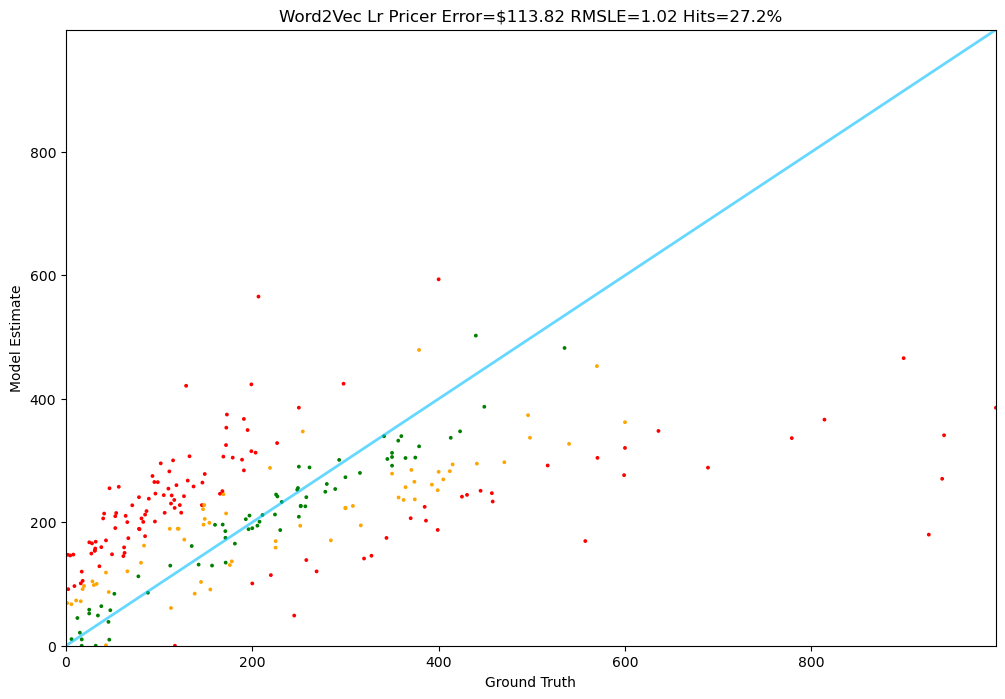

In [63]:
Tester.test(word2vec_lr_pricer, test)

### Model 5: Support Vector Regression

In [64]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [65]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $238.36 Truth: $374.41 Error: $136.05 SLE: 0.20 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $183.53 Truth: $225.11 Error: $41.58 SLE: 0.04 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $131.47 Truth: $61.68 Error: $69.79 SLE: 0.56 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $302.11 Truth: $599.99 Error: $297.88 SLE: 0.47 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $70.91 Truth: $16.99 Error: $53.92 SLE: 1.92 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $249.12 Truth: $101.79 Error: $147.33 SLE: 0.79 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $207.04 Truth: $289.00 Error: $81.96 SLE: 0.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $294.83 Truth: $635.86 Error: $341.03 SLE: 0.59 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $109.98 Truth: $65.99 Error: $43.99 SLE: 0

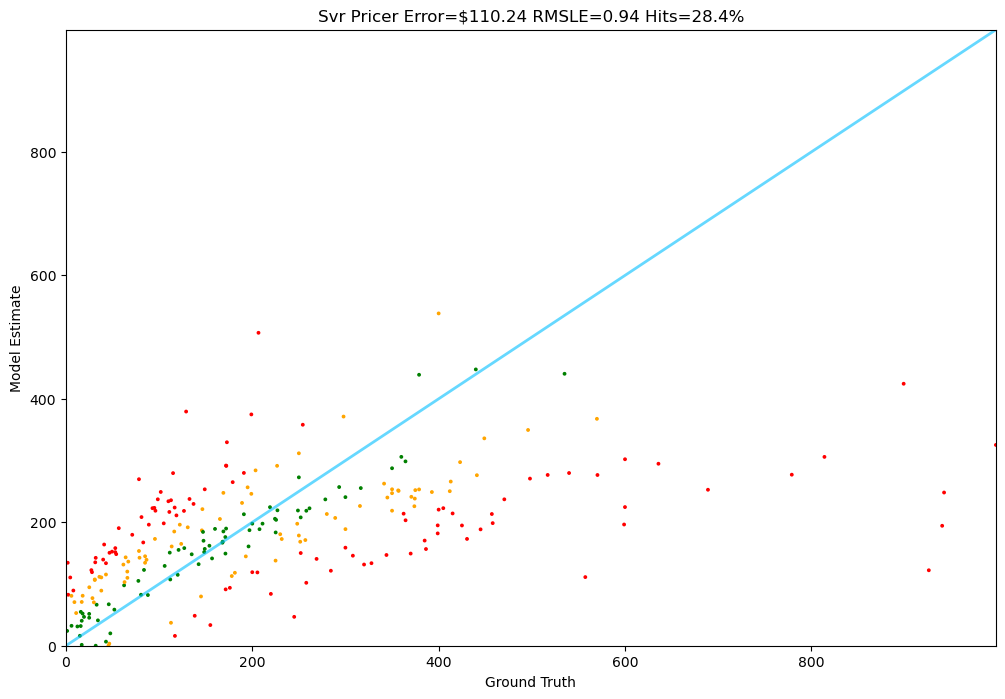

In [66]:
Tester.test(svr_pricer, test)

### Model 6: Random Forest Regression

In [83]:
# And the powerful Random Forest regression

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_estimators=20, n_jobs=8, random_state=42)

In [84]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $345.86 Truth: $374.41 Error: $28.55 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $192.40 Truth: $225.11 Error: $32.71 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $151.49 Truth: $61.68 Error: $89.81 SLE: 0.79 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $368.04 Truth: $599.99 Error: $231.95 SLE: 0.24 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $156.53 Truth: $16.99 Error: $139.54 SLE: 4.71 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $53.79 Truth: $31.99 Error: $21.80 SLE: 0.26 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $307.17 Truth: $101.79 Error: $205.38 SLE: 1.21 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $194.39 Truth: $289.00 Error: $94.61 SLE: 0.16 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $310.12 Truth: $635.86 Error: $325.74 SLE: 0.51 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $118.28 Truth: $65.99 Error: $52.29 SLE: 

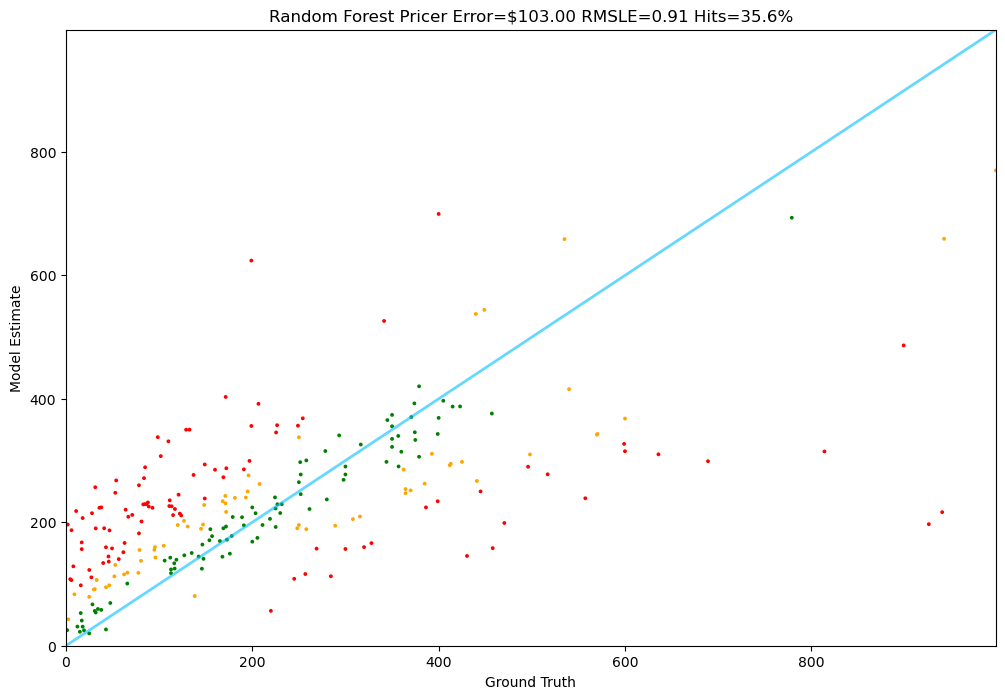

In [85]:
Tester.test(random_forest_pricer, test)

-------
-------
-------

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

### First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [68]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [69]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [70]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [71]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [72]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [73]:
test[0].price

374.41

1: Guess: $180.00 Truth: $374.41 Error: $194.41 SLE: 0.53 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $49.99 Truth: $101.79 Error: $51.80 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $599.00 Truth: $289.00 Error: $310.00 SLE: 0.53 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10

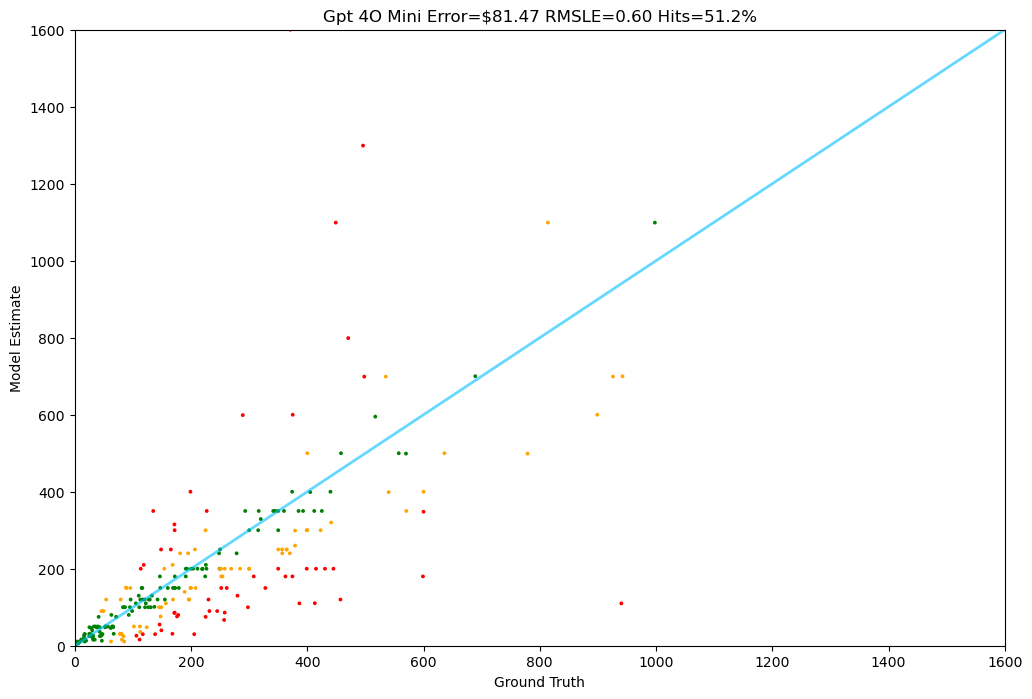

In [74]:
Tester.test(gpt_4o_mini, test)

In [75]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $280.00 Truth: $374.41 Error: $94.41 SLE: 0.08 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $30.00 Truth: $61.68 Error: $31.68 SLE: 0.50 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $450.00 Truth: $599.99 Error: $149.99 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $23.99 Truth: $16.99 Error: $7.00 SLE: 0.11 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.00 Truth: $31.99 Error: $16.99 SLE: 0.52 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $110.00 Truth: $101.79 Error: $8.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.99 Truth: $289.00 Error: $110.99 SLE: 0.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $500.00 Truth: $635.86 Error: $135.86 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 I

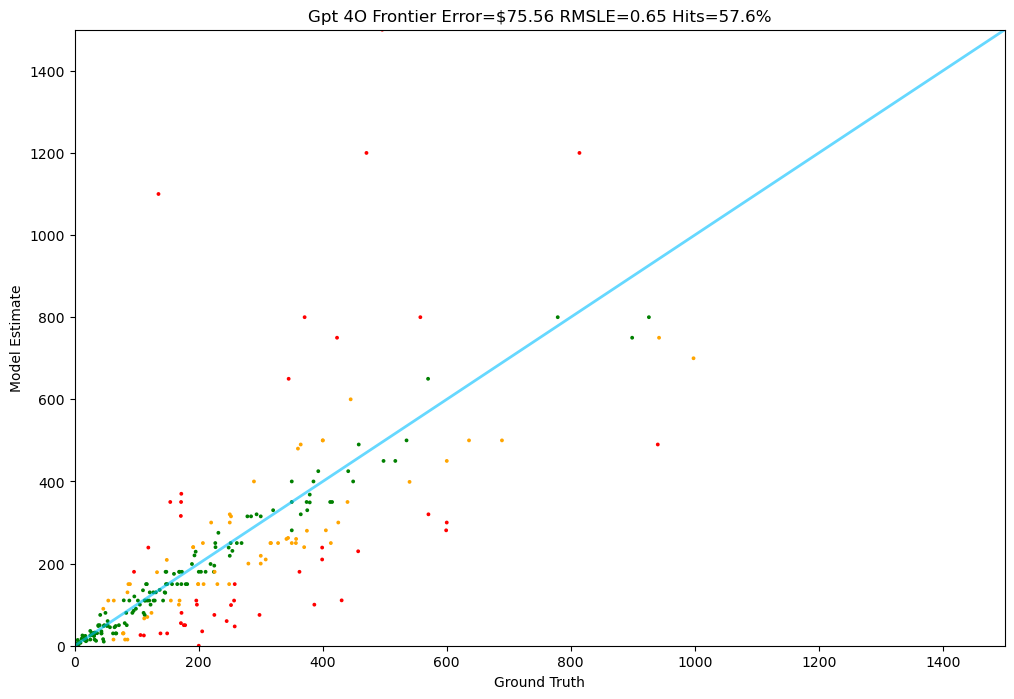

In [79]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [77]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $279.99 Truth: $374.41 Error: $94.42 SLE: 0.08 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $79.99 Truth: $225.11 Error: $145.12 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $39.99 Truth: $61.68 Error: $21.69 SLE: 0.18 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $499.99 Truth: $599.99 Error: $100.00 SLE: 0.03 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.99 Truth: $16.99 Error: $2.00 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $19.99 Truth: $31.99 Error: $12.00 SLE: 0.20 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $84.99 Truth: $101.79 Error: $16.80 SLE: 0.03 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $499.00 Truth: $289.00 Error: $210.00 SLE: 0.30 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $399.99 Truth: $635.86 Error: $235.87 SLE: 0.21 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 It

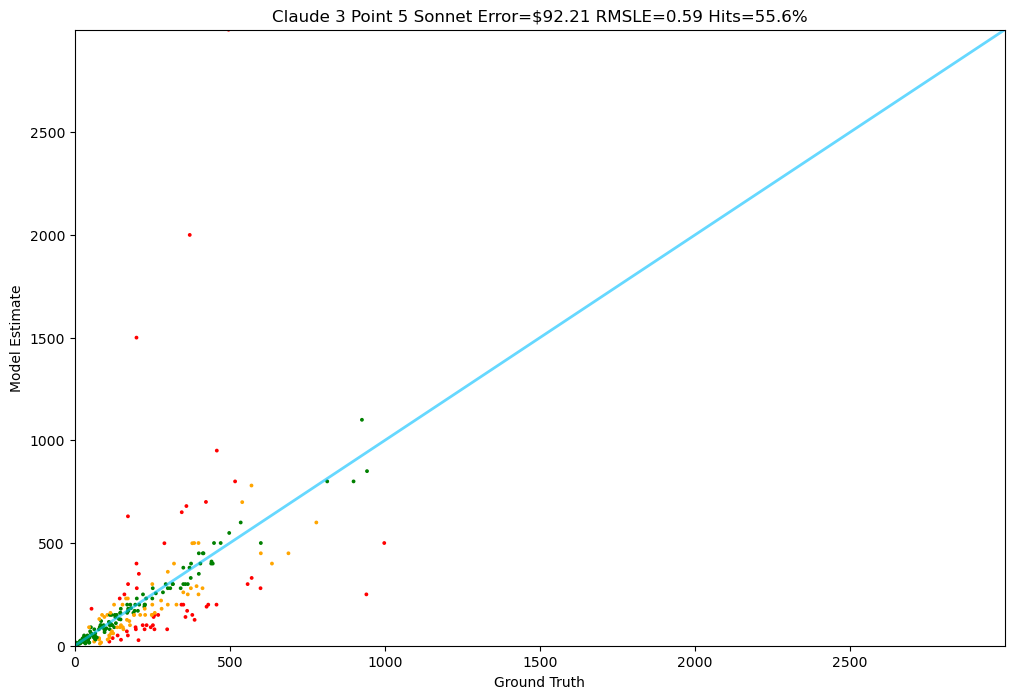

In [78]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)